Note: This notebook requires `ggnewscale` which could be installed by running `devtools::install_github("eliocamp/ggnewscale")` in R

In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(ggnewscale)

import pandas as pd
import numpy as np
from utils import pd2r

Load the NBA POTW dataset

In [2]:
nba_potw = pd2r(pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv'))

Count the number of POTWs received by each team per season and rename `Season short` to `Year`

In [3]:
nba_potw_team_agg = (nba_potw.groupby(['Team', 'Season short'])[['Date']].count().reset_index()
                     .rename(columns = {'Season short': 'Year', 'Date': 'Potw_Count'}))

Load the NBA Yearly Summary dataset and assign the `isChampion` flag to the champion team per season

In [4]:
nba_summary = pd.read_csv('../data/scraped/NBA_Yearly_Summary.csv')
nba_summary = nba_summary[['Year', 'League Champion']].rename(columns = {'League Champion': 'Team'}).assign(isChampion = 'Yes')

Load the NBA Team Colors dataset

In [5]:
nba_colors = pd.read_csv('../data/scraped/NBA_Teams_Color.csv')

Join the NBA POTW and Yearly Summary datasets and insert "No" for `isChampion` for teams who did not win for the season

In [6]:
nba_df = pd.merge(nba_potw_team_agg, nba_summary, on = ['Year', 'Team'], how = 'left')
nba_df.isChampion = nba_df.isChampion.where((pd.notnull(nba_df.isChampion)), 'No')

Assign the `isMaxPotw` flag to the team with the largest number of POTW

In [7]:
max_potw = nba_df.groupby('Year')[['Potw_Count']].max().reset_index().assign(isMaxPotw = 'Yes')
nba_df_potw = pd.merge(nba_df, max_potw, on = ['Year', 'Potw_Count'], how = 'left')
nba_df_potw.isMaxPotw = nba_df_potw.isMaxPotw.where((pd.notnull(nba_df_potw.isMaxPotw)), 'No')

Only consider data after the 1989 - 1990 season to align with the Salary dataset

In [8]:
nba_df_potw = nba_df_potw.loc[nba_df_potw.Year > 1990]

Find the misidentified teams from the dataset

In [9]:
nba_color_missing = pd.merge(nba_df, nba_colors, left_on = 'Team', right_on = 'Franchise', how = 'left')
list(nba_color_missing.loc[nba_color_missing.Color1.isna()]['Team'].unique())

['Charlotte Bobcats',
 'New Jersey Nets',
 'New Orleans Hornets',
 'Philadelphia Sixers',
 'Washington Bullets']

Rename the misidentified teams

In [10]:
missing_teams = {'Charlotte Bobcats': 'Charlotte Hornets', 'New Jersey Nets': 'Brooklyn Nets', 'New Orleans Hornets': 'New Orleans Pelicans', 'Philadelphia Sixers': 'Philadelphia 76ers', 'Washington Bullets': 'Washington Wizards'}
nba_df['Team'] = nba_df['Team'].replace(missing_teams)

Extract the team colors from the dataset

In [11]:
nba_colors = nba_colors.set_index('Franchise')
nba_ggplot_fill = nba_colors['Color1']
nba_ggplot_color = nba_colors['Color2']

Extract the champion teams and non-champion teams

In [12]:
nba_champ = nba_df_potw.loc[nba_df_potw.isChampion == 'Yes']
nba_nonchamp = nba_df_potw.loc[(nba_df_potw.isChampion == 'No')]

Add the Abbreviation for the champion team name 

In [13]:
nba_Abb = pd.read_csv('../data/scraped/NBA_Teams_Abb.csv')

In [14]:
nba_champ = (pd.merge(nba_champ,nba_Abb, left_on= 'Team', right_on='Franchise')
             .drop(columns = 'Franchise').rename(columns = {'Abbreviation/Acronym':'Abb'}))

Pipe DataFrames into R

In [15]:
%R -i nba_champ
%R -i nba_nonchamp
%R -i nba_ggplot_color
%R -i nba_ggplot_fill

Draw `ggplot`

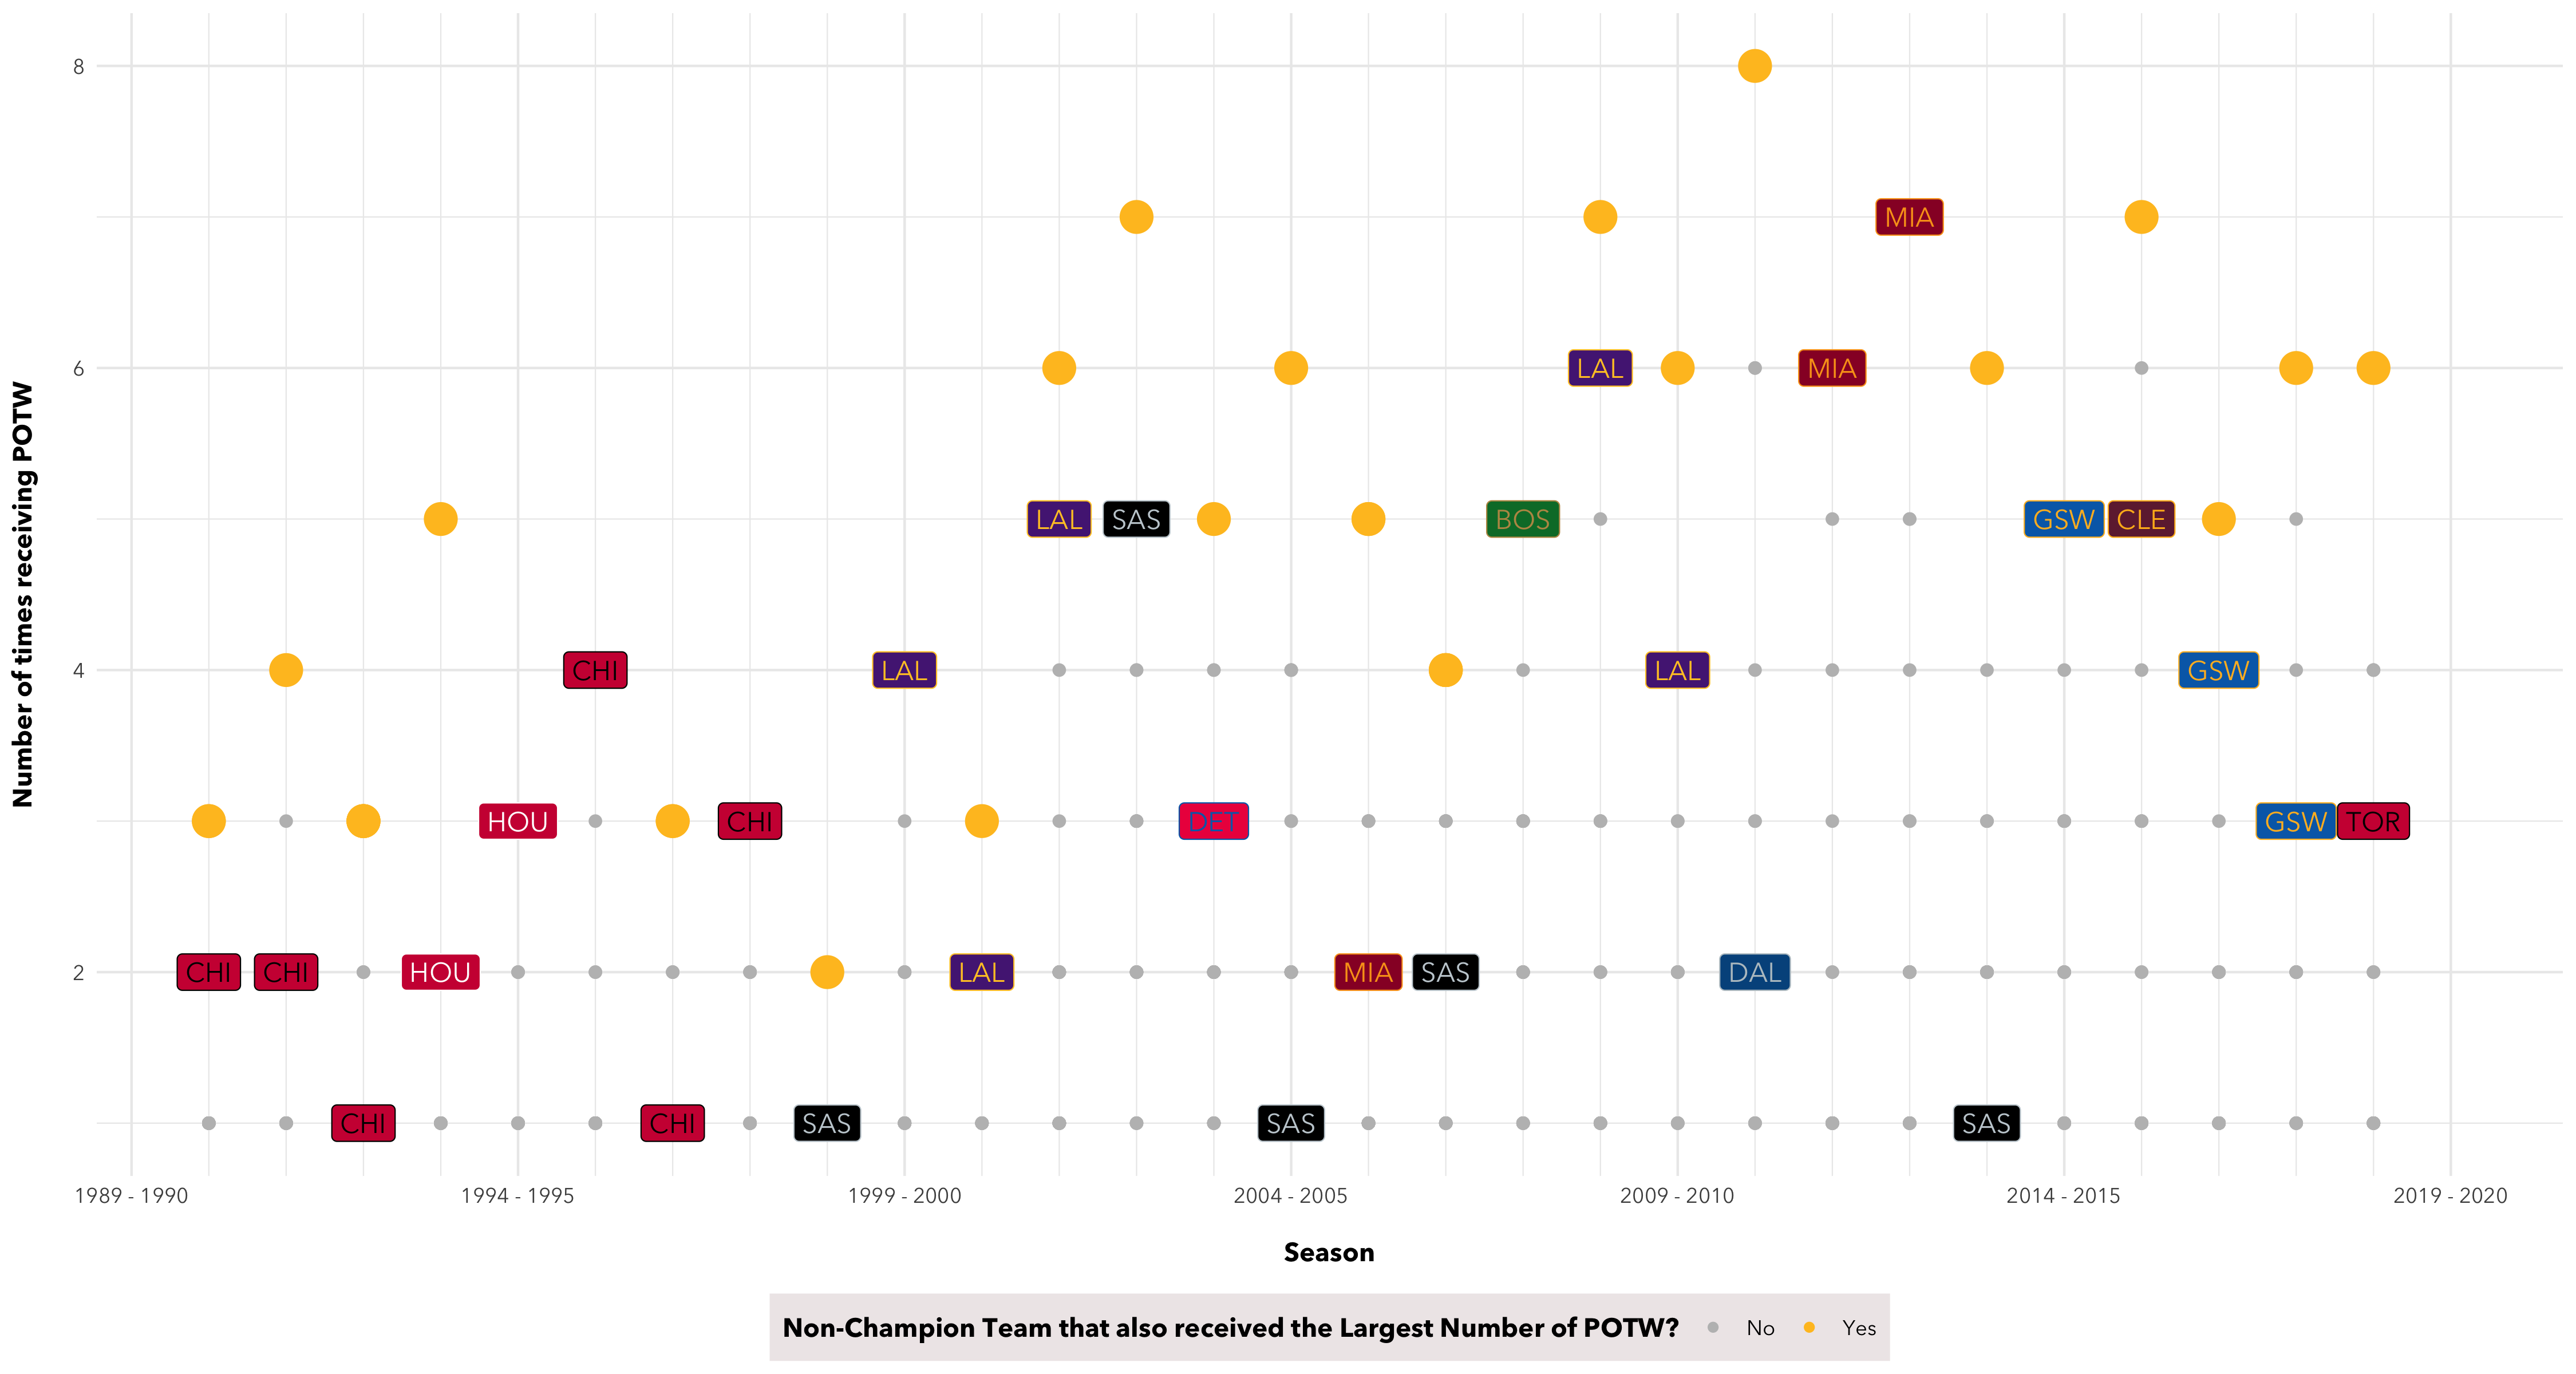

In [16]:
%%R -w 15 -h 8 --units in -r 300
season <- function(x) {
    paste(x - 1, '-', x)
}

ggplot() +
geom_point(aes(x = Year, y = Potw_Count, color = isMaxPotw, size = isMaxPotw), data = nba_nonchamp) +
scale_color_manual(name = 'Non-Champion Team that also received the Largest Number of POTW?', values = c('gray', 'goldenrod1')) +
new_scale_color() +
geom_label(aes(x = Year, y = Potw_Count, color = Team, fill = Team, label = Abb),
           data = nba_champ, size = 4, family = 'Avenir Next') +
scale_color_manual(values = nba_ggplot_color) +
scale_fill_manual(values = nba_ggplot_fill) +
scale_x_continuous(name = '\nSeason', label = season, limit = c(1991, 2020),
                   breaks = seq(1990, 2020, 5), minor_breaks = seq(1991, 2019, 1)) +
scale_y_continuous(name = 'Number of times receiving POTW\n') +
theme_minimal() +
theme(text = element_text(family = 'Avenir Next'),
      axis.title = element_text(face = 'bold'),
      legend.title = element_text(face = 'bold'),
      legend.position = 'bottom',
      legend.background = element_rect(size = 0, fill = 'snow2')) +
guides(fill = F, color = F, size = F)